In [1]:
library(magrittr)
library(tidyverse)
library(readxl)
library(forcats)
library(modelr)
library(broom)
library(aod)
library(plotROC)
library(cowplot)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Warning message:
“package ‘tibble’ was built under R version 3.4.1”Warning message:
“package ‘tidyr’ was built under R version 3.4.2”Warning message:
“package ‘purrr’ was built under R version 3.4.2”Warning message:
“package ‘dplyr’ was built under R version 3.4.2”Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats
Warning message:
“package ‘broom’ was built under R version 3.4.3”
Attaching package: ‘broom’

The following object is masked from ‘package:modelr’:

    bootstrap

Warning message:
“package ‘plotROC’ was built under R version 3.4.1”Warning message:
“package ‘cowplot’ was built under R version 3.4.3”
Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



## Exploration

Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the driver signups took a first trip? (2 points)

Answer: 6137/54681 = 11.2% of driver signups took a first trip.


In [2]:
data = read_excel('driver_signup_data.xlsx', na = c('', 'NA'))

Based on my exploratory analysis (see below), I decided to add a few derived variables to the data set that might be helpful in my modeling.

In [3]:
days_to_x = function(x, start) { as.numeric(difftime(x, start, units=c('days')))}

data %<>%
  mutate(
    # indicator for Sunday signups
    signup_sunday           = weekdays(signup_date) == 'Sunday',
    
    # vehicle year categories using 2000 and 2010 as cutoffs
    vehicle_year_category   = ifelse(vehicle_year <= 2000, '<=2000', ifelse(between(vehicle_year, 2001, 2010), '2001 to 2010', '>=2011')),
    
    # days from signup until certain events
    days_to_bgc             = days_to_x(bgc_date, signup_date),
    days_to_vehicle_added   = days_to_x(vehicle_added_date, signup_date),
    days_to_first_completed = days_to_x(first_completed_date, signup_date),
    
    # days between background check and adding vehicle
    days_bgc_to_vehicle     = days_to_x(vehicle_added_date, bgc_date),
    
    # indicators for having completed certain events
    has_bgc                 = !is.na(bgc_date),
    has_vehicle             = !is.na(vehicle_added_date),
    has_completed           = !is.na(first_completed_date)    
  ) %<>% #drivers first completed date < bgc date 
  filter(is.na(bgc_date) | is.na(first_completed_date) | bgc_date <= first_completed_date)


In [4]:
head(data)

id,city_name,signup_os,signup_channel,signup_date,bgc_date,vehicle_added_date,vehicle_make,vehicle_model,vehicle_year,first_completed_date,signup_sunday,vehicle_year_category,days_to_bgc,days_to_vehicle_added,days_to_first_completed,days_bgc_to_vehicle,has_bgc,has_vehicle,has_completed
1,Strark,ios web,Paid,2016-01-02,NA,NA,NA,NA,NA,NA,FALSE,NA,NA,NA,NA,NA,FALSE,FALSE,FALSE
2,Strark,windows,Paid,2016-01-21,NA,NA,NA,NA,NA,NA,FALSE,NA,NA,NA,NA,NA,FALSE,FALSE,FALSE
3,Wrouver,windows,Organic,2016-01-11,2016-01-11,NA,NA,NA,NA,NA,FALSE,NA,0,NA,NA,NA,TRUE,FALSE,FALSE
4,Berton,android web,Referral,2016-01-29,2016-02-03,2016-02-03,Toyota,Corolla,2016,2016-02-03,FALSE,>=2011,5,5,5,0,TRUE,TRUE,TRUE
5,Strark,android web,Referral,2016-01-10,2016-01-25,2016-01-26,Hyundai,Sonata,2016,NA,TRUE,>=2011,15,16,NA,1,TRUE,TRUE,FALSE
6,Strark,android web,Referral,2016-01-18,2016-01-18,2016-01-22,Cadillac,DTS,2006,NA,FALSE,2001 to 2010,0,4,NA,4,TRUE,TRUE,FALSE


### Completion rate  by city 
* The completion rates of Strark, Berton, and Wrouver are 11%, 12% and 9% respectively. 
* The number of signups in Wrouver is roughly 1/6 of that in Strack and 1/4 of that in Wrouver
* The completion rates of the three cities don't appear to differ notably.

In [32]:
quick.stats <- function(tbl) {
    tbl %>% summarise(
        signups = n(),
      
        # Proportion of signups who completed their first ride
        completion_rate = sum(has_completed) / n(),
      
        # The average number of signups needed to yield one first completed ride
        # This can be another metric for assessing the effectiveness of driver recruitment.
        number_needed = 1 / completion_rate
    )
}

In [22]:
data %>% 
    group_by(city_name) %>%
    quick.stats  %>%
    arrange(desc(signups))

city_name,signups,completion_rate,number_needed
Strark,29557,0.1095849,9.125347
Berton,20117,0.1211413,8.254822
Wrouver,5007,0.0920711,10.861171


### Completion rate by signup channel
* The completion rates of Organic, Paid, and Referral are 9%, 6%, and 20% respectively.
* The drivers who signed up through Referral are much more likely to complete the first trip compared with those who signed up through the other channels 

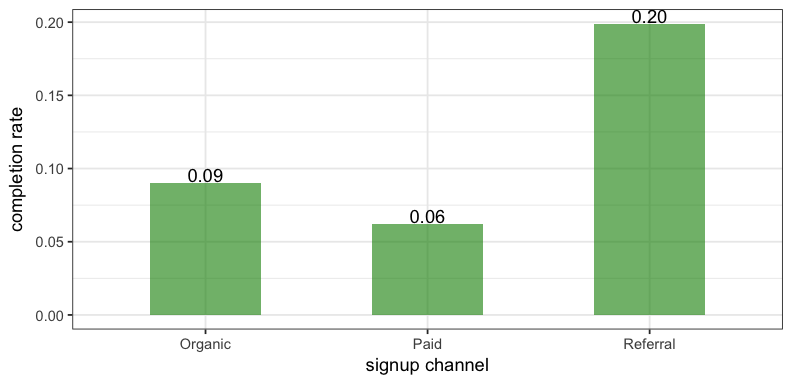

In [28]:
options(repr.plot.width= 6.6, repr.plot.height=3.2)
data %>% 
    group_by(signup_channel) %>%
    quick.stats  %>%
    arrange(desc(signups)) %>%
  ggplot(aes(x = signup_channel, width = 0.5, y = completion_rate)) + 
    geom_bar(stat = 'identity', fill = 'green4', alpha = 0.6)+
    geom_text(aes(label = sprintf("%0.2f", round(completion_rate, digits = 2))), vjust = -0.1) + 
    xlab('signup channel') + 
    ylab('completion rate') +
    theme_bw()

### Completion rate by signup operating system 
* It is worth mentioning that drivers with missing signup os had only a 2% completion rate, given that they account for 12.5% of the study population. 
* Missing signup os is a strong indicator of not completing a first ride. 

In [29]:
data %>% 
    group_by(signup_os) %>%
    quick.stats 

signup_os,signups,completion_rate,number_needed
android web,14944,0.09729657,10.277854
ios web,16632,0.13173401,7.591054
mac,5824,0.16277473,6.143460
other,3648,0.13651316,7.325301
windows,6776,0.13252656,7.545657
NA,6857,0.02158378,46.331081


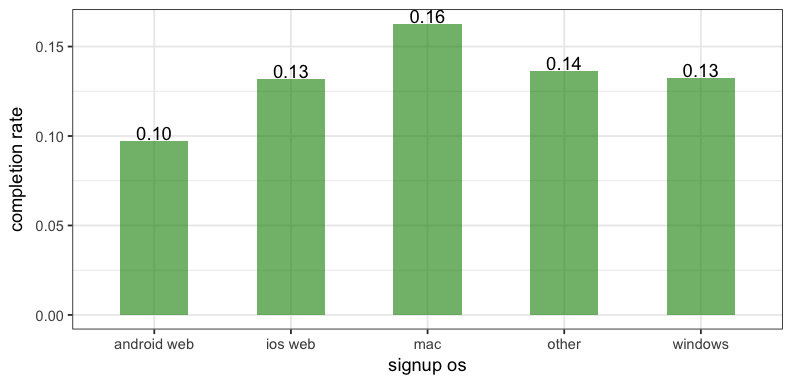

In [30]:
options(repr.plot.width= 6.6, repr.plot.height=3.2)
data %>% 
    group_by(signup_os) %>%
    quick.stats  %>%
    filter(signup_os != 'NA') %>%
  ggplot(aes(x = fct_inorder(signup_os), y = completion_rate)) + 
    geom_bar(stat = 'identity', width = 0.5, fill = 'green4', alpha = 0.6)+
    geom_text(aes(label = sprintf("%0.2f", round(completion_rate, digits = 2))), vjust = -0.1) + 
    xlab('signup os') + 
    ylab('completion rate')+
    theme_bw()

### Completion rate vs vehicle make & vehicle year

#### Vehicle make
* The bar plot shows the completion rate of each vehicle make. The error bar shows the confidence interval of the completion rate. Wider error bars are due to smaller sample size.
* The bar is ordered by the sample size within each category (vehicle make) in a descending order. 
* There are no obivous differences in completion rates 
  * amoung the top 10 vehicle makes by volume. 
  * between economy cars (Toyota, Honda, Nissan) vs luxury cars (Benz, Lexus, BMW)

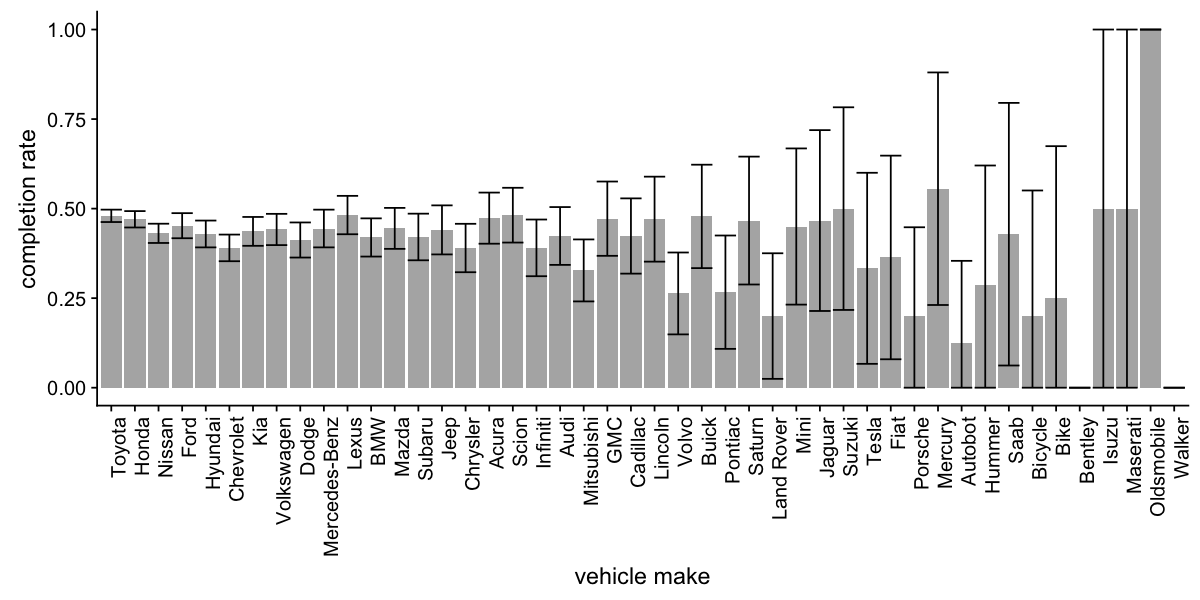

In [31]:
options(repr.plot.width=10, repr.plot.height= 5)

data %>%
  subset(!is.na(vehicle_added_date)) %>%
  group_by(vehicle_make) %>%
  quick.stats %>%
  mutate(
     p = completion_rate,
     p_upper = pmin(1, p + 1.96 * sqrt(p * (1 - p) / signups)),
     p_lower = pmax(0, p - 1.96 * sqrt(p * (1 - p) / signups))
  ) %>%
  arrange(desc(signups)) %>%
  ggplot(aes(x=fct_inorder(vehicle_make), y=p, ymin=p_lower, ymax=p_upper)) + 
    geom_bar(stat='identity', alpha=0.5) + 
    geom_errorbar() + 
    xlab('vehicle make') + 
    scale_y_continuous(name='completion rate') + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1))

##### Completion rate by vehicle year
* The year category (before 2000) have  few data points. 
* There seems to be a slight increasing trend in completion rates since 2001 and the trend appears to stablizie after 2011.   
* I plan to create a new feature to categorize vehicle years: <= 2000, between 2001 and 2010, >= 2011

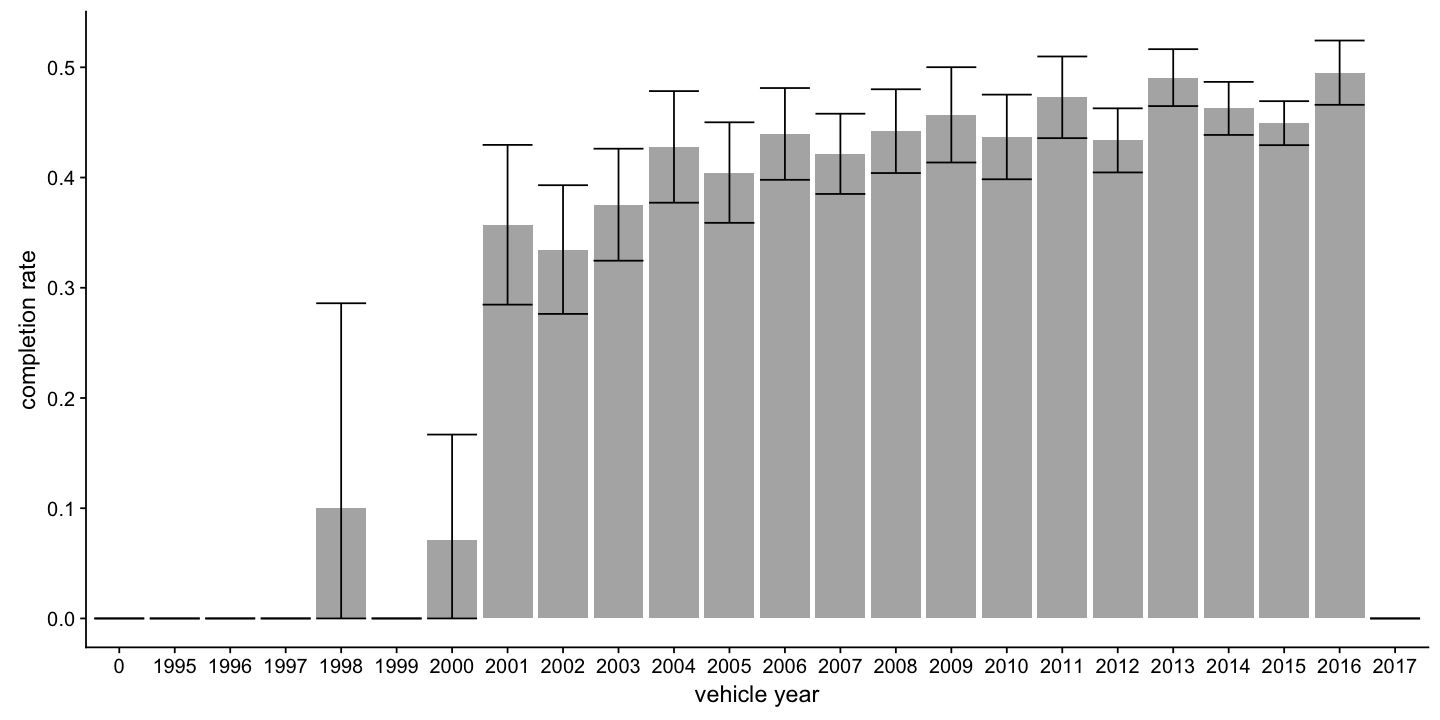

In [32]:
options(repr.plot.width=12, repr.plot.height=6)

data %>%
  subset(!is.na(vehicle_added_date)) %>%
  group_by(vehicle_year) %>%
  quick.stats %>%
  mutate(
    p = completion_rate,
    p_upper = pmin(1, p + 1.96 * sqrt(p * (1 - p) / signups)),
    p_lower = pmax(0, p - 1.96 * sqrt(p * (1 - p) / signups))
  ) %>%
  arrange(desc(signups)) %>%
  ggplot(aes(x=as.factor(vehicle_year), y=p, ymin=p_lower, ymax=p_upper)) + 
    geom_bar(stat='identity', alpha=0.5) + 
    geom_errorbar() + 
    xlab('vehicle year')+
    scale_y_continuous(name='completion rate')


### Numbers of signups at each stage
Summary Stat:
* 60% drivers completed background check 
* For drivers who completed background check, 39% of them added vehicle 
* For drivers who added vehicle and completed background check, 45% completed the first trip
* There are 33 drivers completed the first trip before background check. I am going to filter those records out. 
* Conclusion: for each step, about half of the drivers can make to the next step.

In [18]:
data %>%
  summarise(
    signup       = n(),
    bgc          = sum(!is.na(bgc_date)),
    bgc_vhc      = sum(!is.na(bgc_date) & !is.na(vehicle_added_date)),
    bgc_vhc_ride = sum(!is.na(bgc_date) & !is.na(vehicle_added_date) & !is.na(first_completed_date))
  )

signup,bgc,bgc_vhc,bgc_vhc_ride
54648,32863,12850,5843


### Exploration on continuous variables
* Of drivers who completed a first trip, 79% had their background check within 5 days of signing up.
* Of drivers who didn't complete a first trip, only 38% did so.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 22829 rows containing non-finite values (stat_bin).”

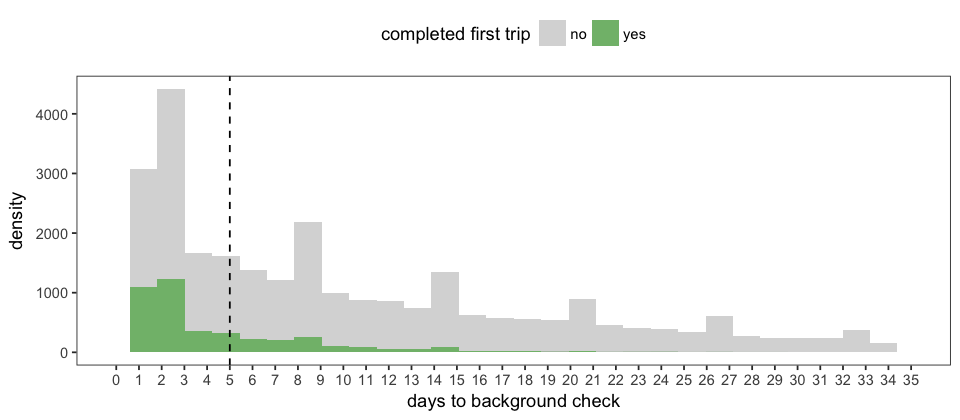

In [34]:
options(repr.plot.width= 8, repr.plot.height=3.5)

data %>% 
    ggplot(aes(x = days_to_bgc)) + 
    geom_histogram(aes(fill = as.factor(has_completed)), alpha = 0.6) + 
    scale_fill_manual(name = "completed first trip", labels = c('no', 'yes'), values = c("grey" , "green4"))+
    xlab('days to background check') + 
    ylab('density')+ 
    scale_x_continuous(breaks = seq(0, 35, 1), lim = c(0, 35)) +
    geom_vline(xintercept = 5, linetype='dashed')+   
    theme_bw() + 
    theme(legend.position="top", 
          panel.grid.major = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank())

### distributions of days between signup and vehicle added 
* Of drivers who completed a first trip, 82.8% added a vehicle within 11 days of signing up. 
* Of drivers who didn't complete the first trip, only 27% did so.

Warning message:
“Removed 43047 rows containing non-finite values (stat_density).”

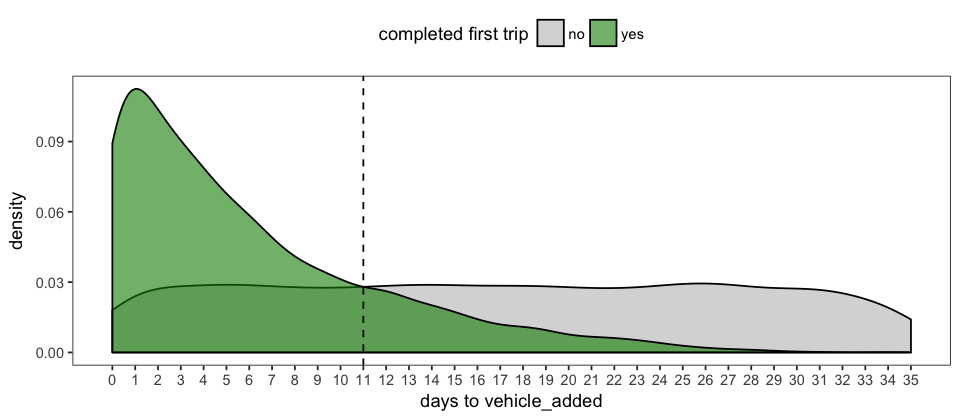

In [40]:
options(repr.plot.width= 8, repr.plot.height=3.5)

data %>% 
    ggplot(aes(x = days_to_vehicle_added)) + 
    geom_density(aes(fill = as.factor(has_completed)), alpha = 0.6) + 
    scale_fill_manual(name = "completed first trip", labels = c('no', 'yes'), values = c("grey" , "green4"))+
    xlab('days to vehicle_added') + 
    ylab('density')+ 
    scale_x_continuous(breaks = seq(0, 35, 1), lim = c(0, 35)) +
    geom_vline(xintercept = 11, linetype='dashed')+   
    theme_bw() + 
    theme(legend.position="top", 
          panel.grid.major = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank())

### Completion rate by signup date
* Both the number of signups and completion rate (by sign up date) showed a weekly periodic pattern with the lowest point on Sundays. 
* For predictive modeling, I plan to create a feature with Sunday indicator for signup dates 

In [45]:
p1 <- data %>% 
    group_by(signup_date) %>%
    quick.stats %>%
    ggplot(aes(signup_date)) + 
    scale_x_datetime(date_breaks = "1 day") + 
    geom_line(aes(y =  signups), color = 'green4', size = 1.5)+
    geom_vline(xintercept = as.numeric(sort(unique(data$signup_date))[c(10, 17, 24)]), linetype='dashed')+  
    xlab('signup dates') + 
    ylab('number of drivers')+ 
    theme_bw()+
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
          panel.grid.major = element_blank(), panel.grid.minor = element_blank())
    

In [46]:
p2 <- data %>% 
    group_by(signup_date) %>%
    quick.stats %>%
    ggplot(aes(x = signup_date)) + 
    scale_x_datetime(date_breaks = "1 day") + 
    geom_line(aes(y =  completion_rate), color = 'green4', size = 1.5)+
    geom_vline(xintercept = as.numeric(sort(unique(data$signup_date))[c(10, 17, 24)]), linetype='dashed')+  
    xlab('signup dates') + 
    ylab('completion rate')+ 
    theme_bw()+
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
          panel.grid.major = element_blank(), panel.grid.minor = element_blank())
    

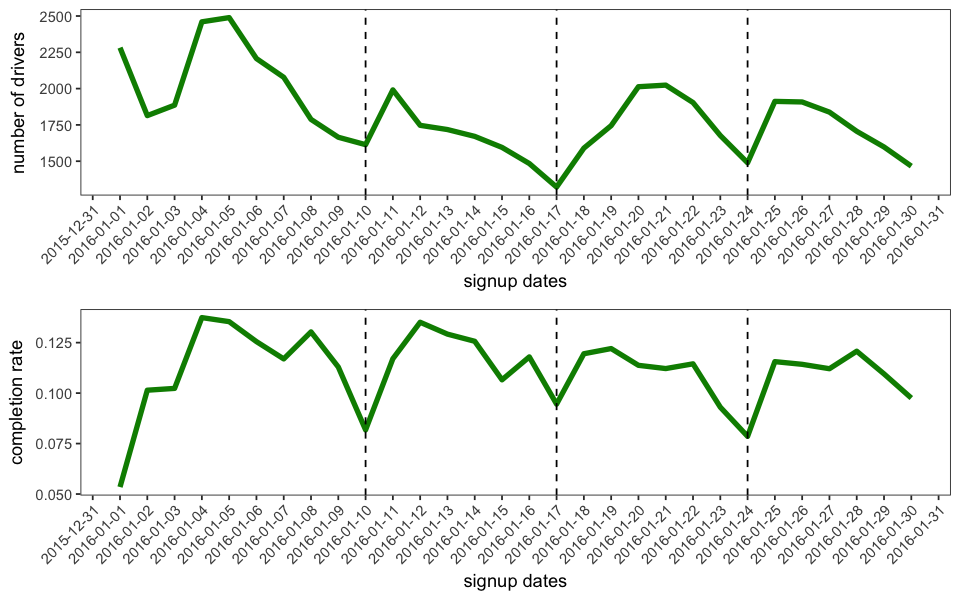

In [47]:
options(repr.plot.width= 8, repr.plot.height= 5)
plot_grid(p1, p2, ncol = 1, align = 'v')

## Modeling 

Build a predictive model to help determine whether or not a driver signup will start driving.
Discuss why you chose your approach, what alternatives you considered, and any concerns you
have. How valid is your model? Include any key indicators of model performance. (2 points)
* I used a logistic regression model because (1) the response varaible is binary (complete or not) and (2) I am interested in the association between the features and the likelihood of completing the first trip. 
* My concerns is the independence of the observations (drivers may influence each other to sign up)
* I used five-fold cross validation to check if there is an overfitting issue 
* I used ROC and AUC to evaluate my model performance because the training set has an imbalanced classes.  AUC score considers the balance between sensitivity and specificity. 

### Logistic regression model: apply to all signups
* New features:
  * has_bgc: if the driver has a background check 
  * has_vehicle_added: if the driver has a vehicle added
  * signup_sunday: if the signup date is a sunday
* Using the binary features has_bgc and has_vehicle_added, 

Model 1: 

$$logit(\pi) = \beta_0 + \beta_1\text{has_bgc} + \beta_2\text{has_vehicle} + \beta_3\text{signup_sunday} + \beta_4\text{signup_channel} + \beta_5\text{signup_os} + \beta_6\text{city_name}$$ 

Model 1 shows that the coefficients of has_bgc, signup_os, signup_channel are statistically significant.

Model 2: 

$$logit(\pi) = \beta_0 + \beta_1\text{has_vehicle} + \beta_2\text{signup_channel} + \beta_3\text{signup_os}$$

Reducing Model 1 to Model 2, the likelihood ratio test shows that Model 2 has a better fit

In [4]:
logit1.1 <- glm(has_completed ~ has_bgc + has_vehicle + signup_sunday + signup_os + signup_channel + city_name , data = data, family = "binomial")

In [28]:
logit1.2 <- glm(has_completed ~ has_vehicle + signup_os + signup_channel + has_vehicle*signup_channel , data = data,  family = "binomial")

In [29]:
summary(logit1.2)


Call:
glm(formula = has_completed ~ has_vehicle + signup_os + signup_channel + 
    has_vehicle * signup_channel, family = "binomial", data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.3331  -0.1604  -0.0746  -0.0602   3.5541  

Coefficients:
                                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)                            -4.80208    0.11355 -42.290  < 2e-16 ***
has_vehicleTRUE                         4.09808    0.11608  35.304  < 2e-16 ***
signup_osios web                        0.15463    0.04469   3.460  0.00054 ***
signup_osmac                            0.45509    0.05761   7.899 2.81e-15 ***
signup_osother                          0.42135    0.07134   5.906 3.50e-09 ***
signup_oswindows                        0.43103    0.05814   7.414 1.23e-13 ***
signup_channelPaid                     -1.51194    0.18483  -8.180 2.84e-16 ***
signup_channelReferral                  0.38433    0.14928   2.575  0.01004 *  
ha

In [33]:
data %>% filter(has_vehicle == 1) %>% group_by(signup_channel) %>% quick.stats

signup_channel,signups,completion_rate,number_needed
Organic,2882,0.3764747,2.656221
Paid,3668,0.3884951,2.574035
Referral,6555,0.5084668,1.966697


#### 5-fold cross validation and model performance
* The average AUC is 0.92.
* The model performances of the five folds are consistent so I don't see an overfitting issue.
* The ROC curve quickly increased to 90% true positive rate with only a 10% false positive rate 
* By plotting the predicted probability for not-completed drivers and completed drivers, we can see almost all predicted probability of negative cases are less than 0.02. After this threshold, changing the threshold does not increase sensitivity much.  

In [23]:
# ffive-fold cross-validation: training the models
models <- data %>%
  select(has_completed, has_vehicle, signup_channel ,  signup_os ) %>%
  crossv_kfold(k = 5) %>%
  mutate(model = map(train, ~ glm(has_completed ~ has_vehicle + signup_channel + signup_os, data = ., family = "binomial")))

# using the models to predict on the test folds
predictions <- models %>%
  unnest(map2(model, test, ~ augment(.x, newdata = .y, type.predict = "response")))

In [31]:
# auc = 0
# for (i in 1: 5){
#     auc = auc + auc(unlist(predictions[predictions['.id']==i, ]['has_completed']), unlist(predictions[predictions['.id']==i, ]['.fitted']))
#     }
# auc/5.

Warning message in verify_d(data$d):
“D not labeled 0/1, assuming FALSE = 0 and TRUE = 1!”

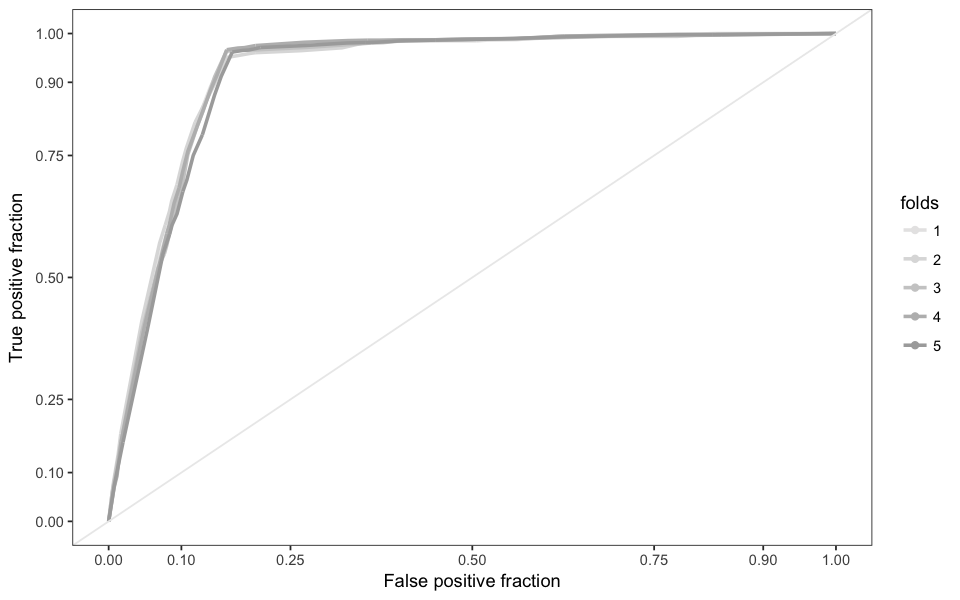

In [54]:
# Plot the ROC curve for each of the five folds
ggplot(predictions, aes(d=has_completed, m=.fitted, color = .id)) +
    scale_colour_manual(name = 'folds', values = c('#e7e6e6', '#dddddd','#cccccc','#bbbbbb','#aaaaaa')) +
    geom_roc(n.cuts = 0) + 
    style_roc() + 
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())

Warning message:
“Removed 6857 rows containing non-finite values (stat_bin).”

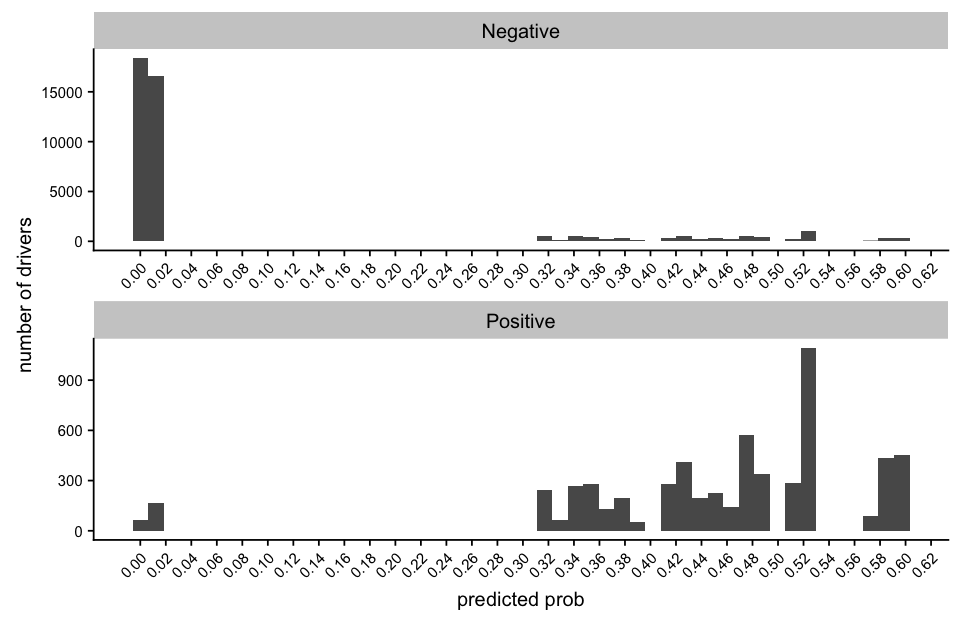

In [56]:
options(repr.plot.width= 8, repr.plot.height= 5.2)

predictions$has_completed_label <- factor(predictions$has_completed, labels = c("Negative", "Positive"))
predictions %>% 
    ggplot(aes(.fitted)) + 
    geom_histogram(bins = 50) + 
    scale_x_continuous('predicted prob', breaks = seq(0, 0.7, 0.02))+
    facet_wrap(~has_completed_label, nrow = 2, scales = "free") + 
    ylab('number of drivers')+
    theme(axis.title = element_text(size = 12),
          axis.text.x = element_text(size = 9, angle = 45, hjust = 1),
          axis.text.y = element_text(size = 9))

### logistic regression: apply to drivers who added vehicle  information
Next, I want to see how the model performs on drivers who conducted background check / added vehicle information.

$$logit(\pi) = \beta_0 + \beta_2\text{days_to_vehicle_added} + \beta_3\text{vehicle_year_category} + \beta_4\text{signup_channel} + \beta_5\text{signup_os} $$ 

The average AUC from five-fold cross-validation is 0.86.

In [7]:
logit2.1 <- glm(has_completed ~ days_to_bgc  + signup_channel + signup_os, data = data, family = "binomial")
logit2.2 <- glm(has_completed ~ days_to_vehicle_added  + signup_sunday + signup_channel + signup_os, data = data, family = "binomial")

In [12]:
summary(logit2.1)


Call:
glm(formula = has_completed ~ days_to_bgc + signup_channel + 
    signup_os, family = "binomial", data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.4547  -0.6933  -0.3654  -0.0729   3.2909  

Coefficients:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)            -1.031279   0.047346 -21.782  < 2e-16 ***
days_to_bgc            -0.172409   0.003567 -48.334  < 2e-16 ***
signup_channelPaid     -0.241523   0.045232  -5.340 9.31e-08 ***
signup_channelReferral  0.988852   0.042144  23.464  < 2e-16 ***
signup_osios web        0.260192   0.041122   6.327 2.49e-10 ***
signup_osmac            0.674095   0.052870  12.750  < 2e-16 ***
signup_osother          0.486781   0.064554   7.541 4.68e-14 ***
signup_oswindows        0.496403   0.052531   9.450  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 30276  on 30837  degree

In [9]:
# Fitting the models 
models <- data %>%
  select(has_completed, days_to_vehicle_added, signup_channel ,  signup_os ) %>%
  crossv_kfold(k = 5) %>%
  mutate(model = map(train, ~ glm(has_completed  ~  days_to_vehicle_added + signup_channel + signup_os , data = ., family = "binomial")))
# Using the models to predict first ride completion
predictions <- models %>%
  unnest(map2(model, test, ~ augment(.x, newdata = .y, type.predict = "response")))

Warning message in verify_d(data$d):
“D not labeled 0/1, assuming FALSE = 0 and TRUE = 1!”

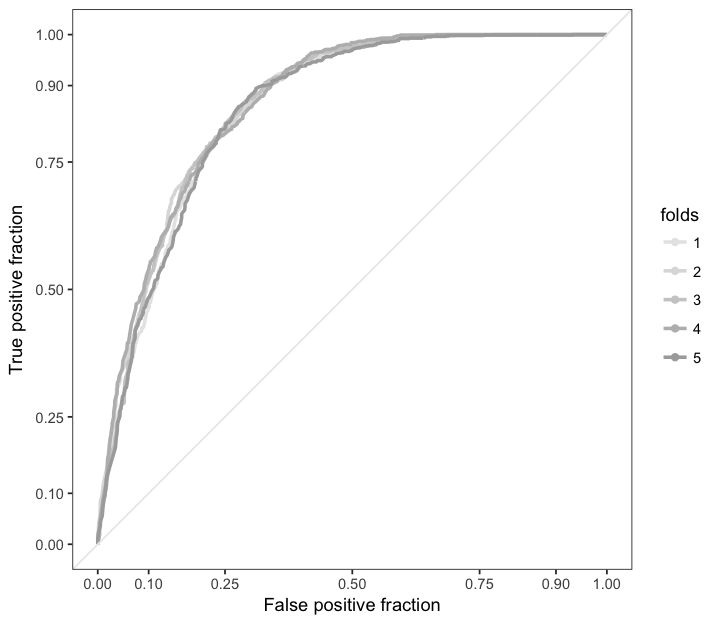

In [10]:
options(repr.plot.width= 6, repr.plot.height= 5.2)
ggplot(predictions, aes(d=has_completed, m=.fitted, color = .id)) +
    scale_colour_manual(name = 'folds', values = c('#e7e6e6', '#dddddd','#cccccc','#bbbbbb','#aaaaaa')) +
    geom_roc(n.cuts = 0) + 
    style_roc()+ 
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())